## Neural networks for segmentation

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/home/ilivans/.virtualenvs/cmn3/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/ilivans/.virtualenvs/cmn3/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


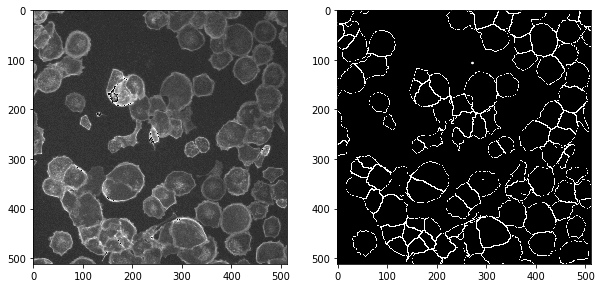

In [2]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im[:,:,1], 'gray')
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

In [3]:
im.shape

(512, 512, 3)

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [4]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

Slightly modified U-Net

Done experiments:

- image size (full vs. 256x256 crops)
- layers number (removed 4 stages (2 up + 2 down) from original architecture)
- number of filters in conv. layers at different stages (no success)
- LR
- Cosine LR Annealing (!cool)
- Fine-tuning with low learing rate (no success)

In [13]:
import torch
import torch.nn.functional as F
from torch import nn


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(1, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.up1 = up(256 + 128, 64)
        self.up2 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x = self.down2(x2)
        x = self.up1(x, x2)
        x = self.up2(x, x1)
        x = self.outc(x)
        return x

In [33]:
from pathlib import Path
from torch.utils.data import Dataset
import warnings
warnings.filterwarnings('ignore')

from PIL import Image


class MyDataset(Dataset):
    def __init__(self, root_dir, root_dir2=None, transform1=None, transform2=None, test=False):
        self.transform1 = transform1
        self.transform2 = transform2
        self.paths = list(sorted(Path(root_dir).iterdir()))
        self.paths_masks = list(sorted(Path(root_dir2).iterdir())) if root_dir2 else None
        self.test = test

    def __len__(self):
        return len(self.paths) * 4

    def __getitem__(self, idx):
        im = io.imread(self.paths[idx // 4])[:,:,1:2]
        mask = io.imread(self.paths_masks[idx // 4])[:,:, None] if (self.paths_masks is not None) else None
    
        if not self.test:
            xi, yi = np.random.randint(0, im.shape[1] - 256, 2)
            im = im[xi: xi + 256, yi: yi + 256]
            if mask:
                mask = mask[xi: xi + 256, yi: yi + 256]
            if np.random.rand() < 0.5:
                im = np.flip(im, 1).copy()
                if mask:
                    mask = np.flip(mask, 1).copy()
            if np.random.rand() < 0.5:
                im = np.flip(im, 0).copy()
                if mask:
                    mask = np.flip(mask, 0).copy()
        else:
            xi = 256 * (idx % 2)
            yi = 256 * min((idx % 4 % 3), 1)
            im = im[xi: xi + 256, yi: yi + 256]
            if mask:
                mask = mask[xi: xi + 256, yi: yi + 256]
    
        seed = np.random.randint(2147483647)
        if self.transform1:
            np.random.seed(seed)
            im = self.transform1(im)            
            if mask is not None:
                np.random.seed(seed)
                mask = self.transform2(mask)
        return im, mask if mask else 0

In [15]:
from scipy.ndimage import io

means = np.array([io.imread(i).mean(axis=(0, 1))[1:2] for i in Path('BBBC018_v1_images-fixed/train').iterdir()]).mean(axis=0)
stds = np.array([io.imread(i).std(axis=(0, 1))[1:2] for i in Path('BBBC018_v1_images-fixed/train').iterdir()]).mean(axis=0)

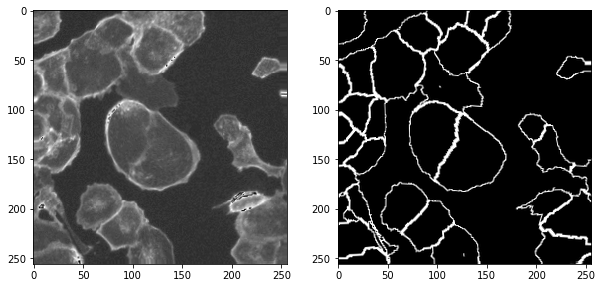

In [16]:
from torchvision import transforms

from imageUtils import ElasticTransform, RandomRotate

transformed_dataset = MyDataset(root_dir='BBBC018_v1_images-fixed/train',
                               root_dir2='BBBC018_v1_outlines/train',
                               transform1=transforms.Compose([
                                   ElasticTransform(alpha=1000, sigma=30),
                                   RandomRotate(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(means, stds)
                                ]),
                               transform2=transforms.Compose([                                   
                                   ElasticTransform(alpha=1000, sigma=30),
                                   RandomRotate(),
                                   transforms.ToTensor()
                                ]))

for i in range(len(transformed_dataset)):
    im, mask = transformed_dataset[i]
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    plt.imshow(((im.numpy()[0] * stds + means)* 255).astype(np.uint8), 'gray')
    plt.subplot(1,2,2)
    plt.imshow(mask.numpy()[0], 'gray')
    plt.show()
    break

In [18]:
import gc
import time

from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable

batch_size = 16
dataset_loader = torch.utils.data.DataLoader(transformed_dataset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=0)

val_loader = torch.utils.data.DataLoader(MyDataset(root_dir='BBBC018_v1_images-fixed/val',
                                                   root_dir2='BBBC018_v1_outlines/val',
                                                   transform1=transforms.Compose([transforms.ToTensor(),
                                                                                  transforms.Normalize(means, stds)]),
                                                   transform2=transforms.ToTensor(),
                                                   test=True),
                                             batch_size=16, shuffle=False,
                                             num_workers=0)
y_val = np.vstack([y.numpy() for x,y in val_loader])

model = UNet(1)
model.cuda()

# opt = torch.optim.Adam(model.parameters(), LR, betas=(0.9, 0.999), weight_decay=WD)

train_loss = []
val_loss = []
val_accuracy = []

class_weight = 0.4

def compute_loss(X_batch, y_batch):
    X_var = Variable(X_batch)
    y_binary = (y_batch > 0).float()
    y_binary_arr = y_binary.numpy()
    y_var = Variable(y_binary)
    logits = model(X_var.cuda())
#     weight = y_binary_arr + (1 - y_binary_arr) / y_binary_arr.sum()
    weight = y_binary_arr * (1 - class_weight) + (1 - y_binary_arr) * class_weight
    weight = Variable(torch.FloatTensor(weight))
    return F.binary_cross_entropy_with_logits(logits.cuda(), y_var.cuda(), weight.cuda()).mean()

def compute_loss_val(X_batch, y_batch):
    X_var = Variable(X_batch)
    y_binary = (y_batch > 0).float()
    y_binary_arr = y_binary.numpy()
    y_var = Variable(y_binary)
    logits = model(X_var.cuda())
#     weight = y_binary_arr + (1 - y_binary_arr) / y_binary_arr.sum()
    weight = y_binary_arr * (1 - class_weight) + (1 - y_binary_arr) * class_weight
    weight = Variable(torch.FloatTensor(weight))
    return F.binary_cross_entropy_with_logits(logits.cuda(), y_var.cuda(), weight.cuda()).mean(), logits


LR = 1e-3
LR_ = LR
LR_STEP = 50
WD = 1e-3
num_epochs = 600
THR = 0.09

for epoch in range(num_epochs):
    if epoch % LR_STEP == 0 and epoch > 0:
        LR_ = LR_ * 0.75
    # Cosine annealing learning rate
    lr = LR_ / 2 * (1 + np.cos(epoch % LR_STEP / LR_STEP * np.pi))
    opt = torch.optim.Adam(model.parameters(), lr, betas=(0.9, 0.999), weight_decay=WD)
    
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in dataset_loader:
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
        gc.collect()
        
    y_pred = []
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_loader:
        loss, logits = compute_loss_val(X_batch, y_batch)
        y_pred.append(logits.cpu().data.numpy())
        val_loss.append(loss.cpu().data.numpy()[0])
        gc.collect()
    
    val_accuracy.append(calc_iou(np.vstack([i > np.sort(i.flatten())[-int(i.size * THR)] for i in y_pred])[:len(y_val)], y_val))
    
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(dataset_loader):])))
    print("  val loss (in-iteration): \t{:.6f}".format(
        val_loss[-1]))
    print("  validation accuracy: \t\t\t{:.3f}".format(
        val_accuracy[-1]))

Epoch 1 of 600 took 17.123s
  training loss (in-iteration): 	0.265789
  val loss (in-iteration): 	0.260725
  validation accuracy: 			0.047
Epoch 2 of 600 took 17.484s
  training loss (in-iteration): 	0.217616
  val loss (in-iteration): 	0.158987
  validation accuracy: 			0.070
Epoch 3 of 600 took 17.217s
  training loss (in-iteration): 	0.212383
  val loss (in-iteration): 	0.122127
  validation accuracy: 			0.065
Epoch 4 of 600 took 17.136s
  training loss (in-iteration): 	0.186826
  val loss (in-iteration): 	0.298313
  validation accuracy: 			0.017
Epoch 5 of 600 took 17.306s
  training loss (in-iteration): 	0.165997
  val loss (in-iteration): 	0.303186
  validation accuracy: 			0.041
Epoch 6 of 600 took 17.304s
  training loss (in-iteration): 	0.162833
  val loss (in-iteration): 	0.118453
  validation accuracy: 			0.076
Epoch 7 of 600 took 17.208s
  training loss (in-iteration): 	0.200527
  val loss (in-iteration): 	0.296019
  validation accuracy: 			0.145
Epoch 8 of 600 took 17.106s

Epoch 60 of 600 took 17.091s
  training loss (in-iteration): 	0.160371
  val loss (in-iteration): 	0.124103
  validation accuracy: 			0.032
Epoch 61 of 600 took 17.139s
  training loss (in-iteration): 	0.066634
  val loss (in-iteration): 	0.211027
  validation accuracy: 			0.005
Epoch 62 of 600 took 17.170s
  training loss (in-iteration): 	0.082562
  val loss (in-iteration): 	0.385072
  validation accuracy: 			0.012
Epoch 63 of 600 took 16.996s
  training loss (in-iteration): 	0.096465
  val loss (in-iteration): 	0.261750
  validation accuracy: 			0.021
Epoch 64 of 600 took 17.102s
  training loss (in-iteration): 	0.159614
  val loss (in-iteration): 	0.170573
  validation accuracy: 			0.052
Epoch 65 of 600 took 17.163s
  training loss (in-iteration): 	0.147273
  val loss (in-iteration): 	0.460324
  validation accuracy: 			0.014
Epoch 66 of 600 took 17.129s
  training loss (in-iteration): 	0.067805
  val loss (in-iteration): 	0.187375
  validation accuracy: 			0.032
Epoch 67 of 600 took

Epoch 119 of 600 took 17.318s
  training loss (in-iteration): 	0.066870
  val loss (in-iteration): 	0.225692
  validation accuracy: 			0.034
Epoch 120 of 600 took 17.202s
  training loss (in-iteration): 	0.082681
  val loss (in-iteration): 	0.474783
  validation accuracy: 			0.135
Epoch 121 of 600 took 17.309s
  training loss (in-iteration): 	0.090882
  val loss (in-iteration): 	0.132985
  validation accuracy: 			0.030
Epoch 122 of 600 took 16.971s
  training loss (in-iteration): 	0.096838
  val loss (in-iteration): 	0.524884
  validation accuracy: 			0.079
Epoch 123 of 600 took 17.151s
  training loss (in-iteration): 	0.061161
  val loss (in-iteration): 	0.467725
  validation accuracy: 			0.060
Epoch 124 of 600 took 17.076s
  training loss (in-iteration): 	0.123424
  val loss (in-iteration): 	0.126424
  validation accuracy: 			0.130
Epoch 125 of 600 took 17.125s
  training loss (in-iteration): 	0.085624
  val loss (in-iteration): 	0.389494
  validation accuracy: 			0.022
Epoch 126 of 

Epoch 178 of 600 took 17.101s
  training loss (in-iteration): 	0.107788
  val loss (in-iteration): 	0.271620
  validation accuracy: 			0.080
Epoch 179 of 600 took 16.908s
  training loss (in-iteration): 	0.071851
  val loss (in-iteration): 	0.545808
  validation accuracy: 			0.114
Epoch 180 of 600 took 16.887s
  training loss (in-iteration): 	0.117786
  val loss (in-iteration): 	0.275205
  validation accuracy: 			0.240
Epoch 181 of 600 took 16.924s
  training loss (in-iteration): 	0.114059
  val loss (in-iteration): 	0.159714
  validation accuracy: 			0.181
Epoch 182 of 600 took 16.890s
  training loss (in-iteration): 	0.111217
  val loss (in-iteration): 	0.212225
  validation accuracy: 			0.170
Epoch 183 of 600 took 17.053s
  training loss (in-iteration): 	0.076514
  val loss (in-iteration): 	0.106536
  validation accuracy: 			0.218
Epoch 184 of 600 took 16.917s
  training loss (in-iteration): 	0.090260
  val loss (in-iteration): 	0.118756
  validation accuracy: 			0.156
Epoch 185 of 

Epoch 237 of 600 took 16.786s
  training loss (in-iteration): 	0.083094
  val loss (in-iteration): 	0.167529
  validation accuracy: 			0.205
Epoch 238 of 600 took 16.807s
  training loss (in-iteration): 	0.084594
  val loss (in-iteration): 	0.138261
  validation accuracy: 			0.267
Epoch 239 of 600 took 16.840s
  training loss (in-iteration): 	0.096903
  val loss (in-iteration): 	0.118702
  validation accuracy: 			0.240
Epoch 240 of 600 took 16.828s
  training loss (in-iteration): 	0.078106
  val loss (in-iteration): 	0.152037
  validation accuracy: 			0.237
Epoch 241 of 600 took 16.847s
  training loss (in-iteration): 	0.093235
  val loss (in-iteration): 	0.139856
  validation accuracy: 			0.290
Epoch 242 of 600 took 16.821s
  training loss (in-iteration): 	0.100436
  val loss (in-iteration): 	0.181046
  validation accuracy: 			0.266
Epoch 243 of 600 took 16.806s
  training loss (in-iteration): 	0.080643
  val loss (in-iteration): 	0.172384
  validation accuracy: 			0.277
Epoch 244 of 

Epoch 296 of 600 took 16.828s
  training loss (in-iteration): 	0.080092
  val loss (in-iteration): 	0.153724
  validation accuracy: 			0.291
Epoch 297 of 600 took 16.827s
  training loss (in-iteration): 	0.047036
  val loss (in-iteration): 	0.153353
  validation accuracy: 			0.291
Epoch 298 of 600 took 16.795s
  training loss (in-iteration): 	0.096410
  val loss (in-iteration): 	0.143721
  validation accuracy: 			0.294
Epoch 299 of 600 took 16.860s
  training loss (in-iteration): 	0.119888
  val loss (in-iteration): 	0.146777
  validation accuracy: 			0.292
Epoch 300 of 600 took 16.897s
  training loss (in-iteration): 	0.077537
  val loss (in-iteration): 	0.150014
  validation accuracy: 			0.292
Epoch 301 of 600 took 16.988s
  training loss (in-iteration): 	0.060667
  val loss (in-iteration): 	0.176999
  validation accuracy: 			0.065
Epoch 302 of 600 took 16.847s
  training loss (in-iteration): 	0.106910
  val loss (in-iteration): 	0.214653
  validation accuracy: 			0.144
Epoch 303 of 

Epoch 355 of 600 took 16.926s
  training loss (in-iteration): 	0.084086
  val loss (in-iteration): 	0.106522
  validation accuracy: 			0.178
Epoch 356 of 600 took 16.995s
  training loss (in-iteration): 	0.110279
  val loss (in-iteration): 	0.207669
  validation accuracy: 			0.117
Epoch 357 of 600 took 16.866s
  training loss (in-iteration): 	0.036997
  val loss (in-iteration): 	0.133284
  validation accuracy: 			0.242
Epoch 358 of 600 took 16.796s
  training loss (in-iteration): 	0.083329
  val loss (in-iteration): 	0.106132
  validation accuracy: 			0.217
Epoch 359 of 600 took 16.856s
  training loss (in-iteration): 	0.042095
  val loss (in-iteration): 	0.157282
  validation accuracy: 			0.163
Epoch 360 of 600 took 16.815s
  training loss (in-iteration): 	0.037158
  val loss (in-iteration): 	0.118212
  validation accuracy: 			0.190
Epoch 361 of 600 took 16.846s
  training loss (in-iteration): 	0.104872
  val loss (in-iteration): 	0.149553
  validation accuracy: 			0.128
Epoch 362 of 

Epoch 414 of 600 took 16.836s
  training loss (in-iteration): 	0.092241
  val loss (in-iteration): 	0.113120
  validation accuracy: 			0.195
Epoch 415 of 600 took 16.831s
  training loss (in-iteration): 	0.154219
  val loss (in-iteration): 	0.310618
  validation accuracy: 			0.153
Epoch 416 of 600 took 16.861s
  training loss (in-iteration): 	0.084823
  val loss (in-iteration): 	0.148416
  validation accuracy: 			0.243
Epoch 417 of 600 took 16.821s
  training loss (in-iteration): 	0.059201
  val loss (in-iteration): 	0.154948
  validation accuracy: 			0.255
Epoch 418 of 600 took 16.894s
  training loss (in-iteration): 	0.118929
  val loss (in-iteration): 	0.218991
  validation accuracy: 			0.264
Epoch 419 of 600 took 16.835s
  training loss (in-iteration): 	0.054662
  val loss (in-iteration): 	0.333212
  validation accuracy: 			0.048
Epoch 420 of 600 took 17.037s
  training loss (in-iteration): 	0.103916
  val loss (in-iteration): 	0.191385
  validation accuracy: 			0.275
Epoch 421 of 

Epoch 473 of 600 took 17.026s
  training loss (in-iteration): 	0.053136
  val loss (in-iteration): 	0.141256
  validation accuracy: 			0.289
Epoch 474 of 600 took 17.159s
  training loss (in-iteration): 	0.060547
  val loss (in-iteration): 	0.257062
  validation accuracy: 			0.273
Epoch 475 of 600 took 16.823s
  training loss (in-iteration): 	0.101943
  val loss (in-iteration): 	0.213606
  validation accuracy: 			0.223
Epoch 476 of 600 took 16.844s
  training loss (in-iteration): 	0.066237
  val loss (in-iteration): 	0.172593
  validation accuracy: 			0.227
Epoch 477 of 600 took 16.965s
  training loss (in-iteration): 	0.090235
  val loss (in-iteration): 	0.142417
  validation accuracy: 			0.276
Epoch 478 of 600 took 16.876s
  training loss (in-iteration): 	0.135631
  val loss (in-iteration): 	0.127117
  validation accuracy: 			0.268
Epoch 479 of 600 took 16.831s
  training loss (in-iteration): 	0.124107
  val loss (in-iteration): 	0.139687
  validation accuracy: 			0.276
Epoch 480 of 

Epoch 532 of 600 took 17.012s
  training loss (in-iteration): 	0.062924
  val loss (in-iteration): 	0.137750
  validation accuracy: 			0.296
Epoch 533 of 600 took 16.840s
  training loss (in-iteration): 	0.093104
  val loss (in-iteration): 	0.139975
  validation accuracy: 			0.296
Epoch 534 of 600 took 16.807s
  training loss (in-iteration): 	0.147435
  val loss (in-iteration): 	0.164122
  validation accuracy: 			0.271
Epoch 535 of 600 took 16.803s
  training loss (in-iteration): 	0.063477
  val loss (in-iteration): 	0.151059
  validation accuracy: 			0.288
Epoch 536 of 600 took 16.862s
  training loss (in-iteration): 	0.030113
  val loss (in-iteration): 	0.146532
  validation accuracy: 			0.293
Epoch 537 of 600 took 16.857s
  training loss (in-iteration): 	0.103295
  val loss (in-iteration): 	0.145441
  validation accuracy: 			0.284
Epoch 538 of 600 took 16.864s
  training loss (in-iteration): 	0.083064
  val loss (in-iteration): 	0.165507
  validation accuracy: 			0.248
Epoch 539 of 

Epoch 591 of 600 took 16.813s
  training loss (in-iteration): 	0.115577
  val loss (in-iteration): 	0.148320
  validation accuracy: 			0.295
Epoch 592 of 600 took 16.803s
  training loss (in-iteration): 	0.051741
  val loss (in-iteration): 	0.146283
  validation accuracy: 			0.298
Epoch 593 of 600 took 16.815s
  training loss (in-iteration): 	0.041889
  val loss (in-iteration): 	0.142554
  validation accuracy: 			0.297
Epoch 594 of 600 took 16.777s
  training loss (in-iteration): 	0.140616
  val loss (in-iteration): 	0.142772
  validation accuracy: 			0.291
Epoch 595 of 600 took 16.839s
  training loss (in-iteration): 	0.110035
  val loss (in-iteration): 	0.143793
  validation accuracy: 			0.294
Epoch 596 of 600 took 16.774s
  training loss (in-iteration): 	0.073693
  val loss (in-iteration): 	0.144339
  validation accuracy: 			0.295
Epoch 597 of 600 took 16.776s
  training loss (in-iteration): 	0.083873
  val loss (in-iteration): 	0.144334
  validation accuracy: 			0.295
Epoch 598 of 

In [19]:
calc_iou(np.vstack([i > np.sort(i.flatten())[-int(i.size * THR)] for i in y_pred])[:len(y_val)], y_val)

0.2948417147853061

Absolute threshold found manually (single variable optimization algorithm from scipy could be used)

In [85]:
calc_iou(np.vstack([i > 1.1 for i in y_pred])[:len(y_val)], y_val)

0.2969244419738305

In [20]:
torch.save(model, 'model.pt')

Predictions on validation set

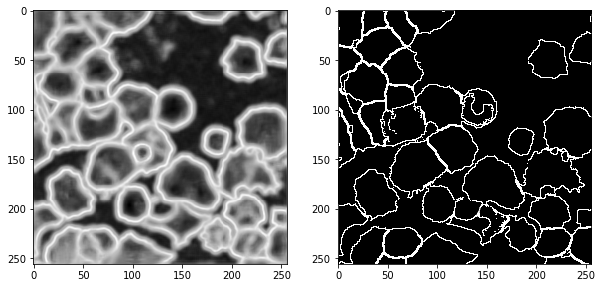

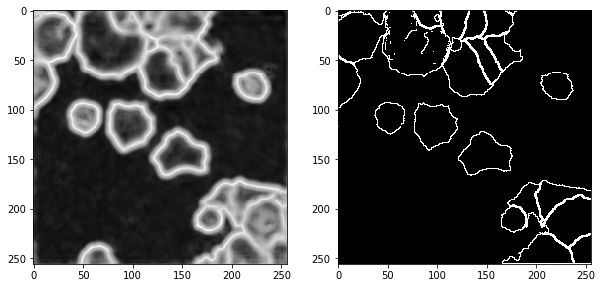

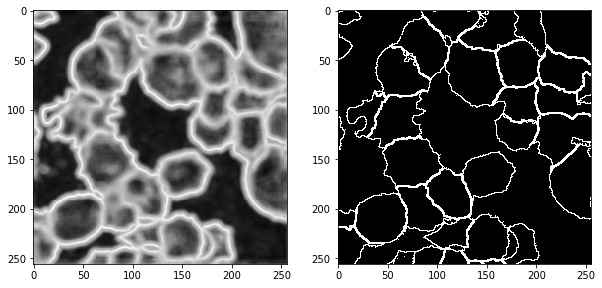

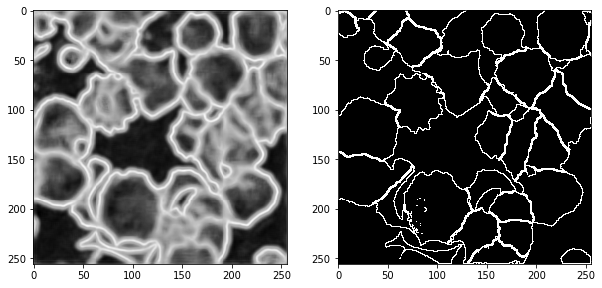

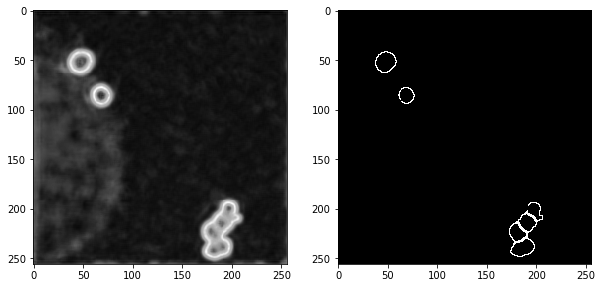

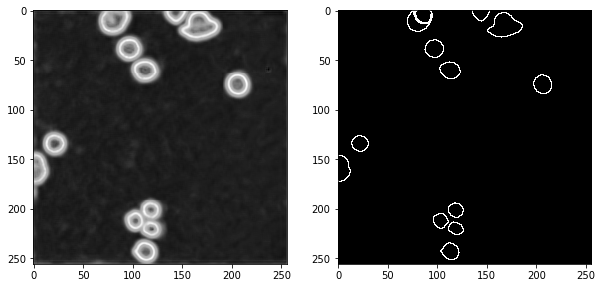

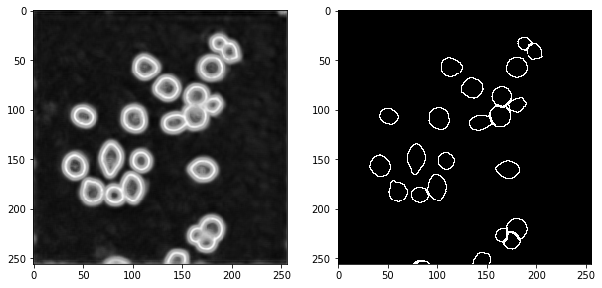

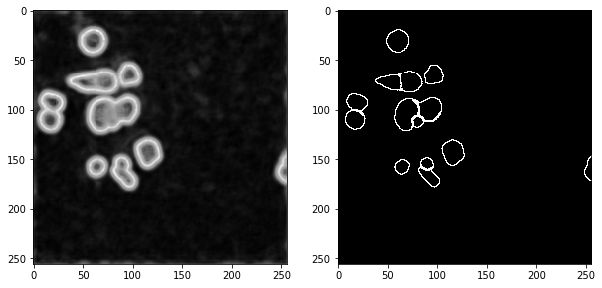

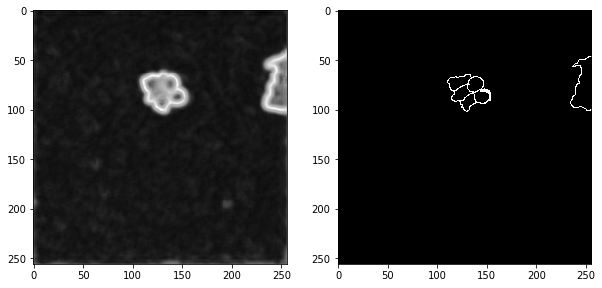

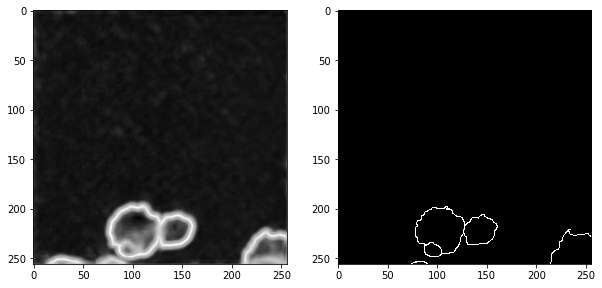

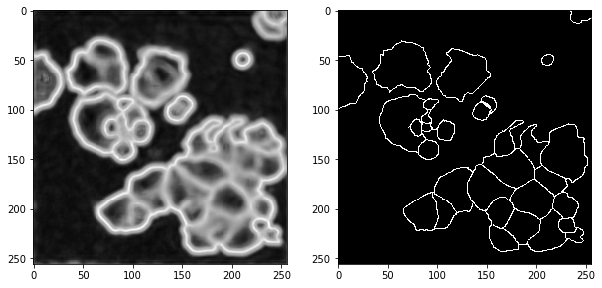

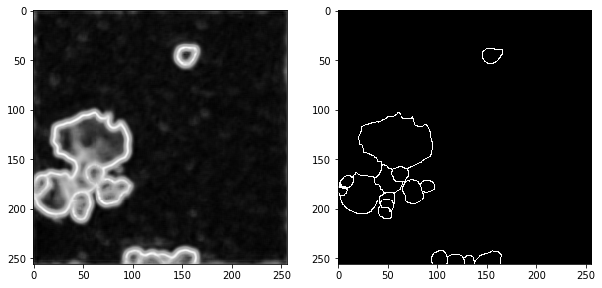

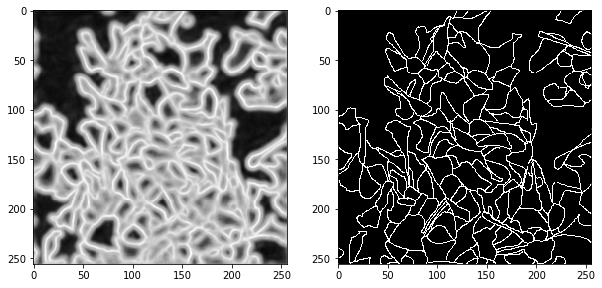

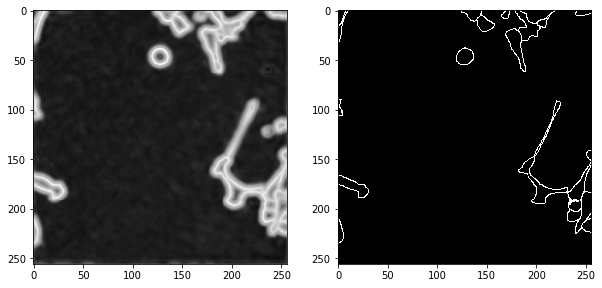

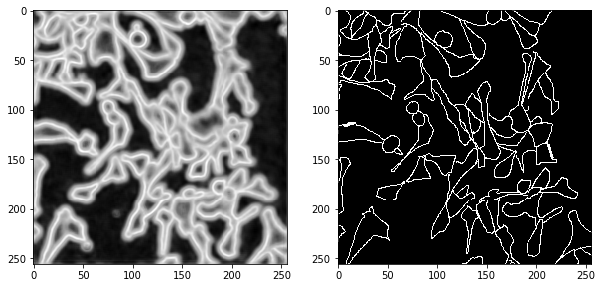

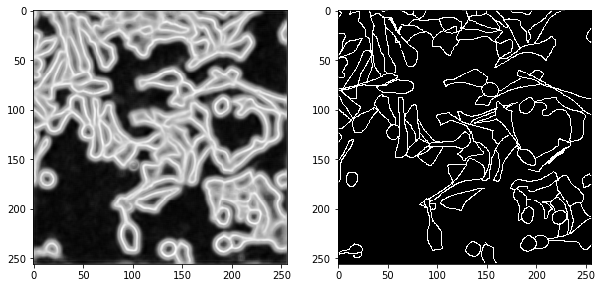

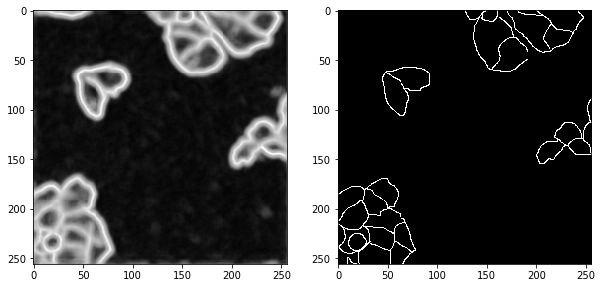

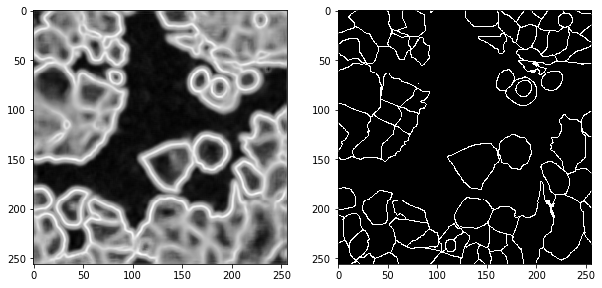

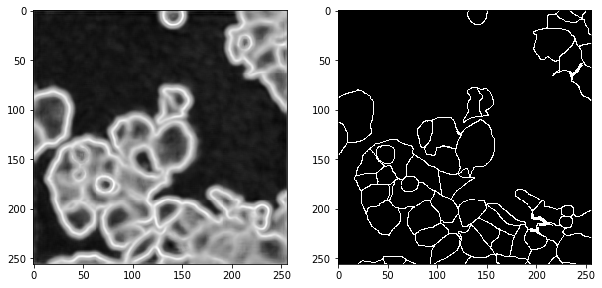

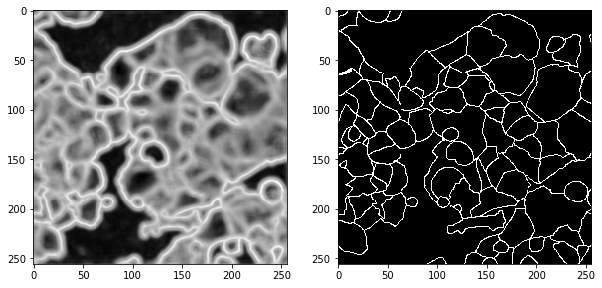

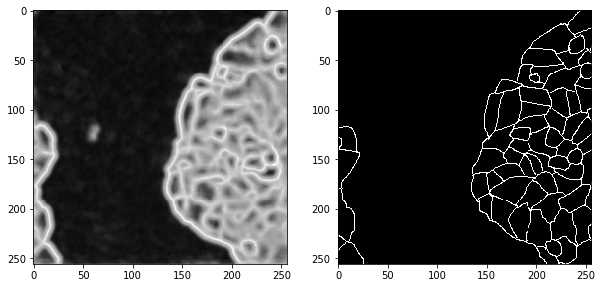

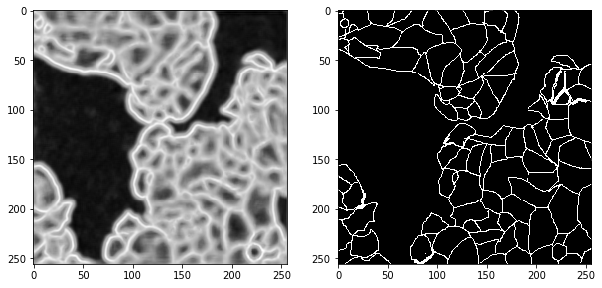

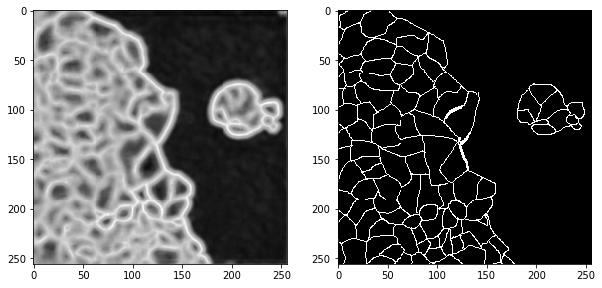

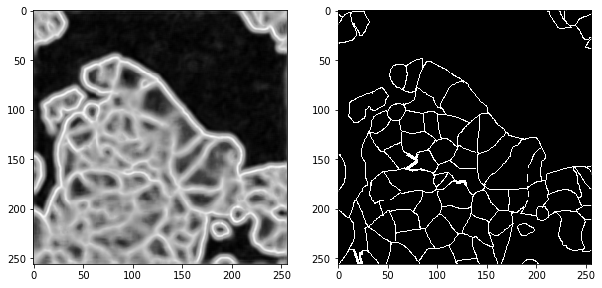

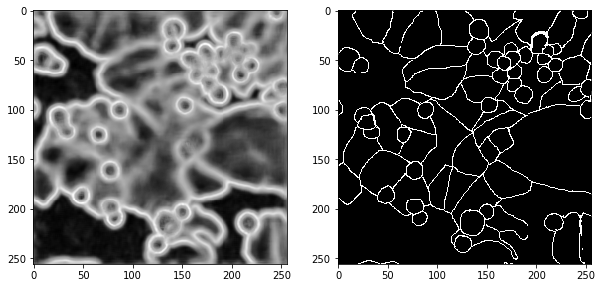

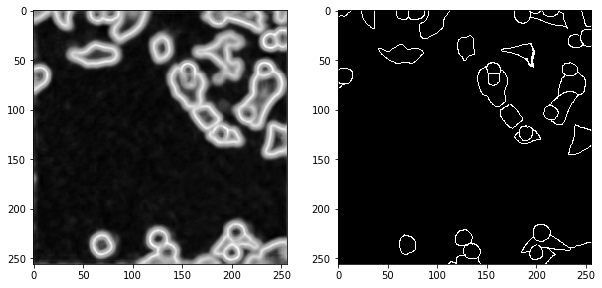

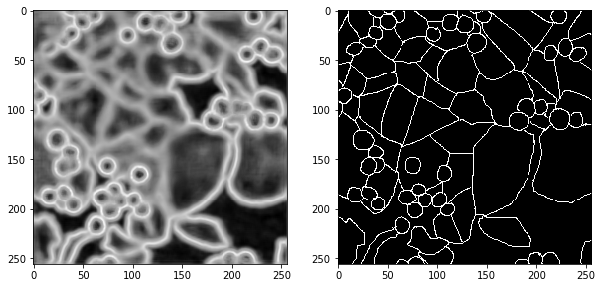

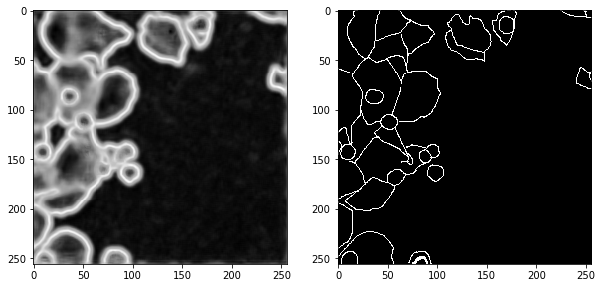

In [27]:
for pred, mask in zip(np.vstack([i for i in y_pred])[:len(y_val)], y_val):
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    plt.imshow(pred[0], 'gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[0], 'gray')
    plt.show()
#     break

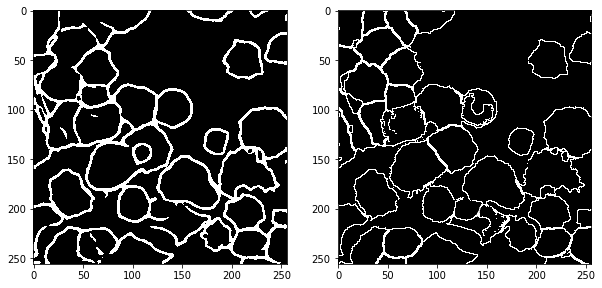

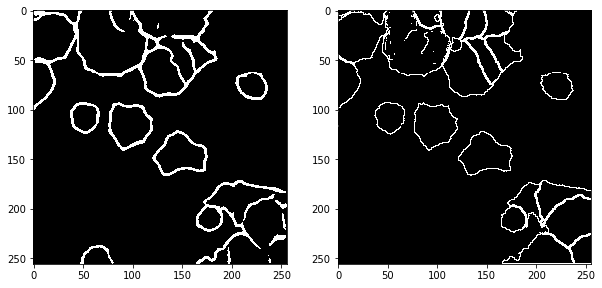

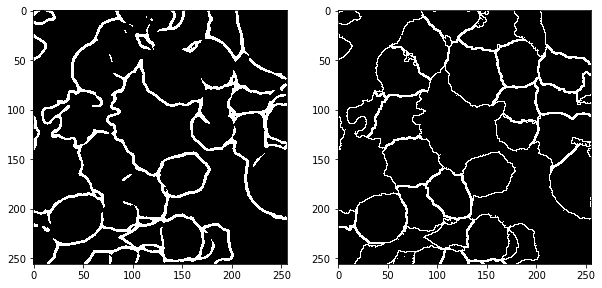

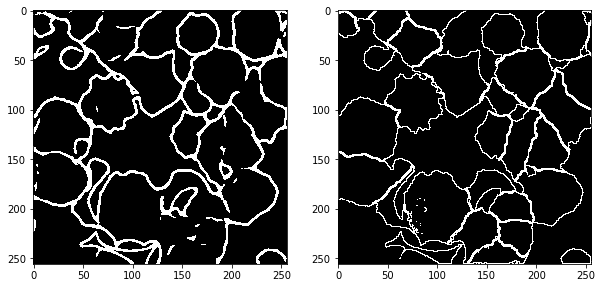

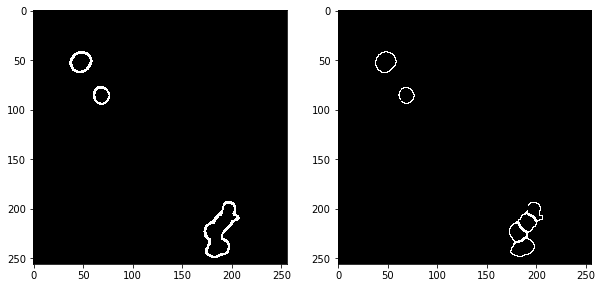

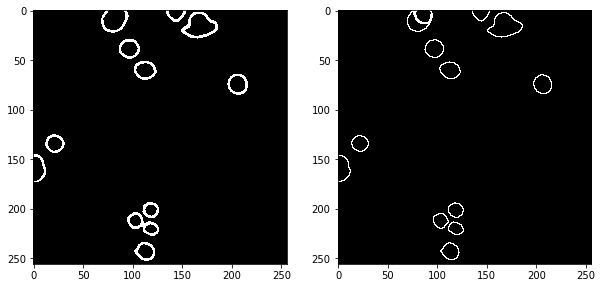

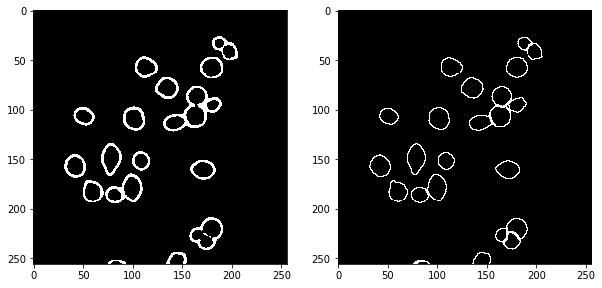

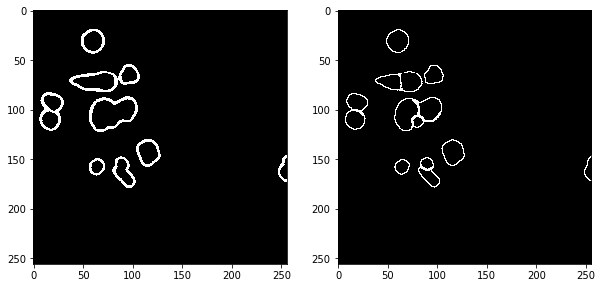

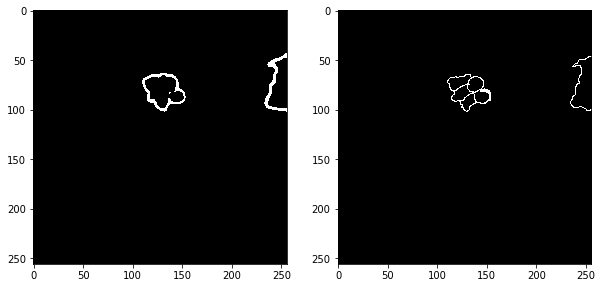

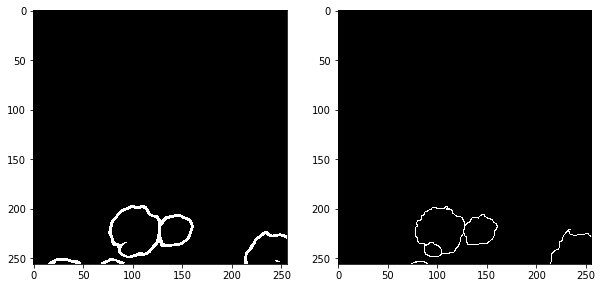

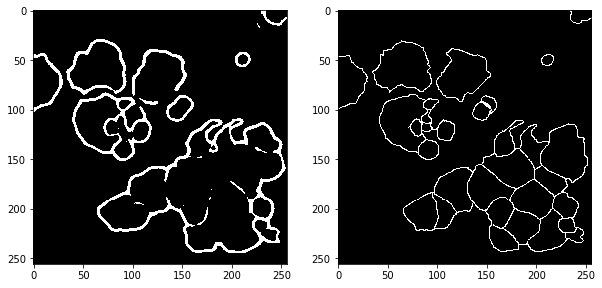

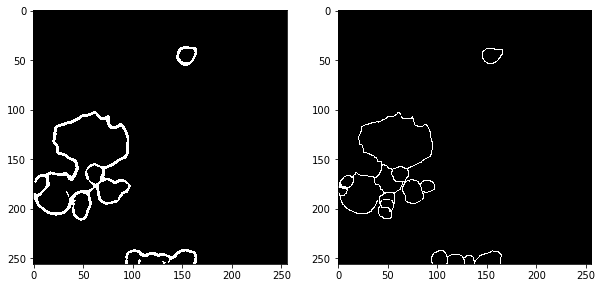

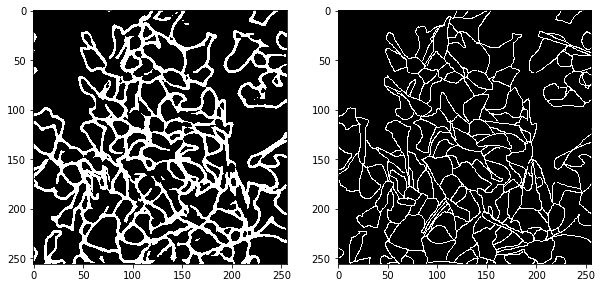

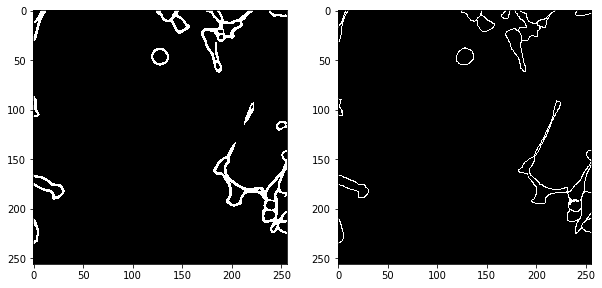

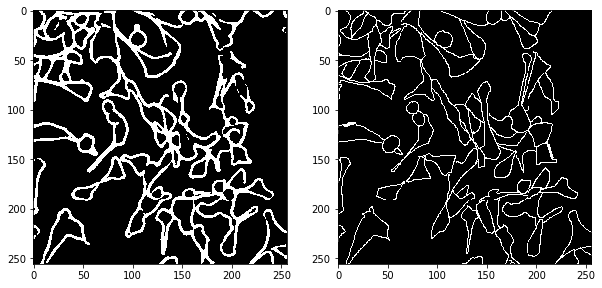

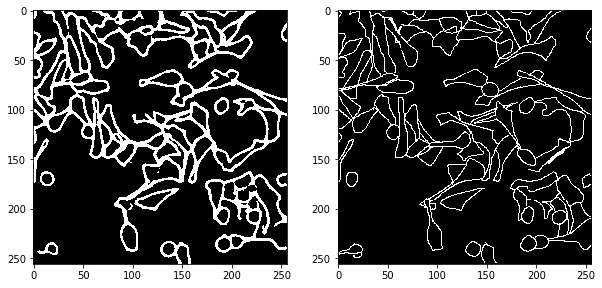

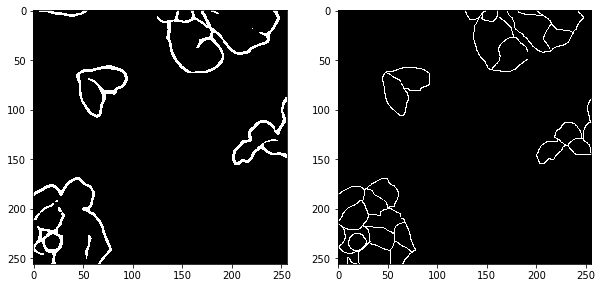

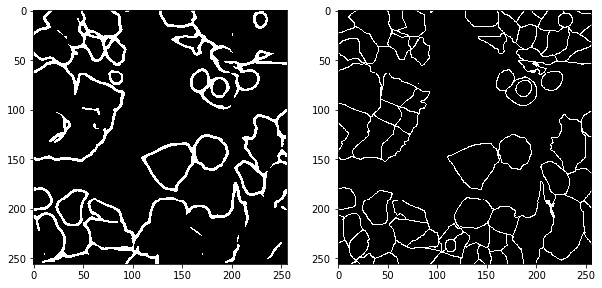

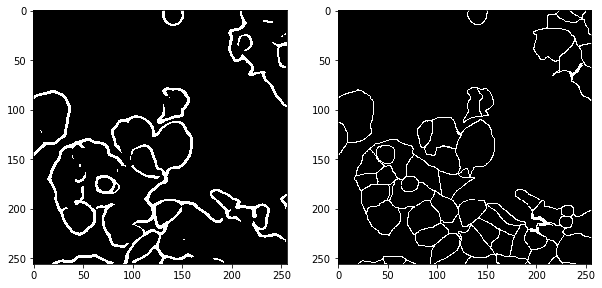

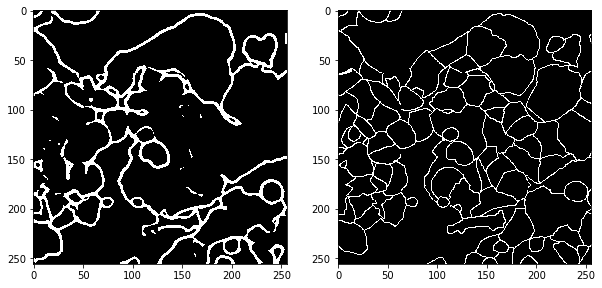

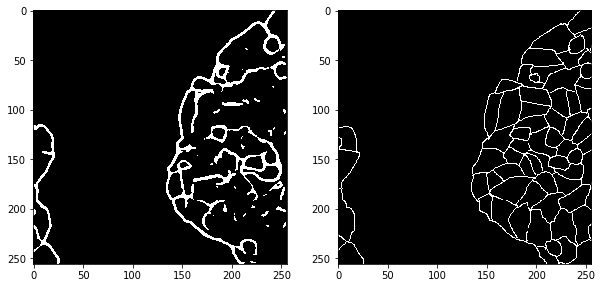

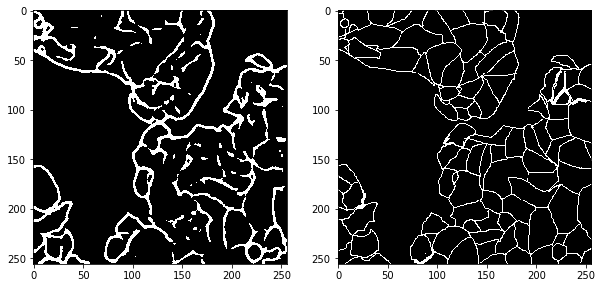

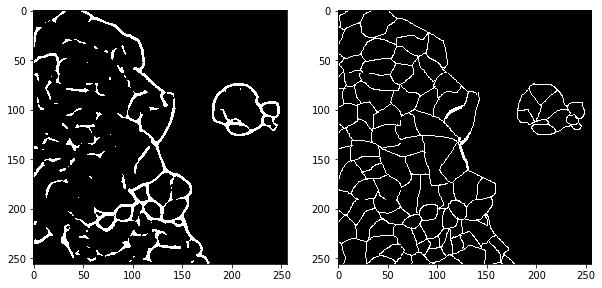

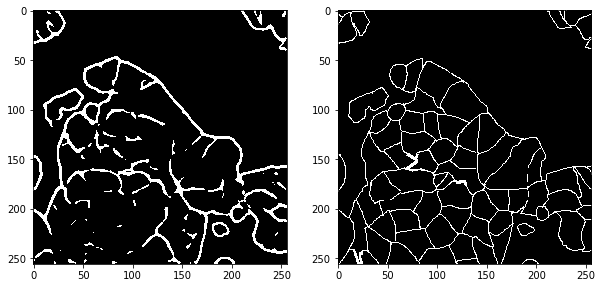

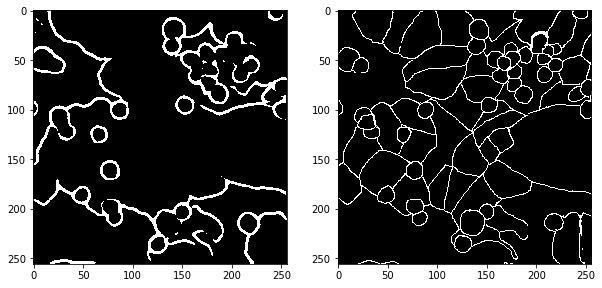

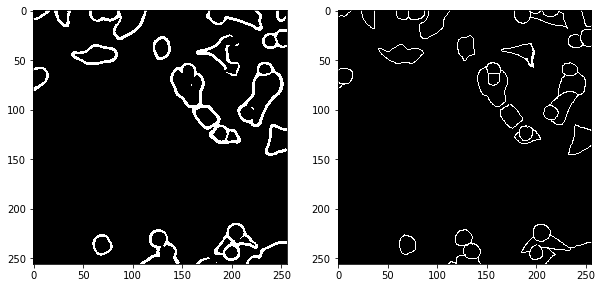

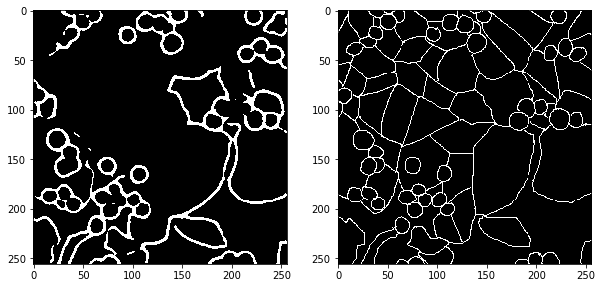

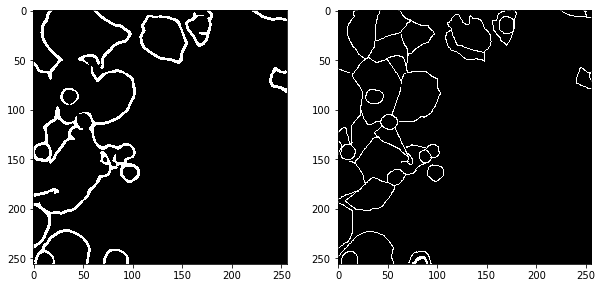

In [28]:
for pred, mask in zip(np.vstack([i > np.sort(i.flatten())[-int(i.size * THR)] for i in y_pred])[:len(y_val)], y_val):
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    plt.imshow(pred[0], 'gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[0], 'gray')
    plt.show()

In [36]:
test_loader = torch.utils.data.DataLoader(MyDataset(root_dir='BBBC018_v1_images-fixed/test/',
                                                   transform1=transforms.Compose([transforms.ToTensor(),
                                                                                  transforms.Normalize(means, stds)]),
                                                   transform2=transforms.ToTensor(),
                                                   test=True),
                                             batch_size=1, shuffle=False,
                                             num_workers=0)

X_test = []
y_test = []
model.train(False)
for X_batch, _ in test_loader:
    X_test += [((x.numpy()[0] * stds + means)* 255).astype(np.uint8) for x in X_batch]
    logits = model(Variable(X_batch).cuda())
    y_test.append(logits.cpu().data.numpy())

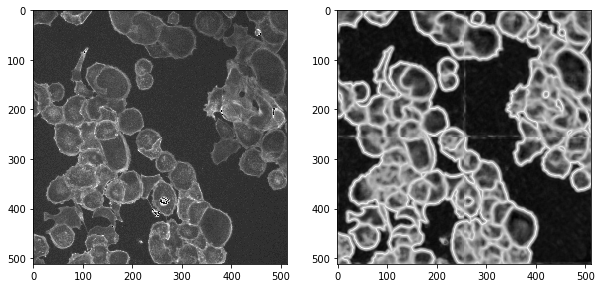

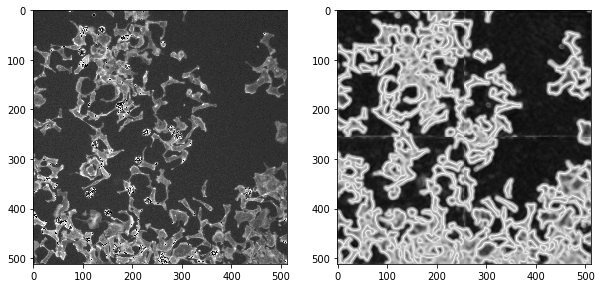

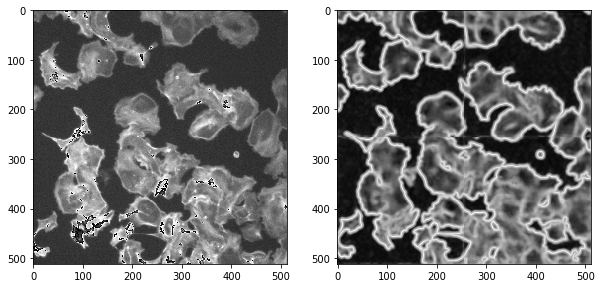

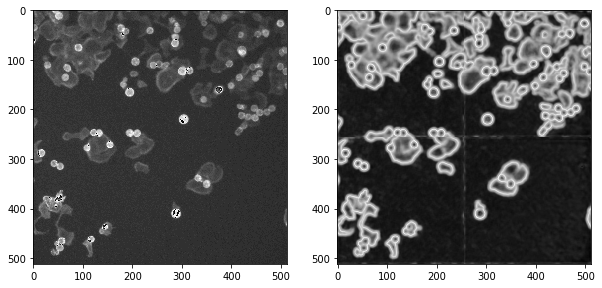

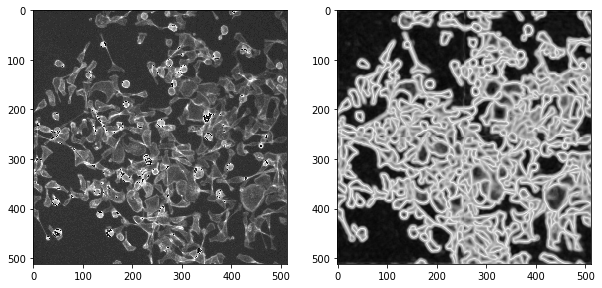

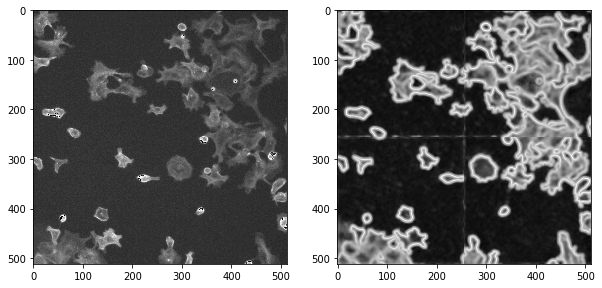

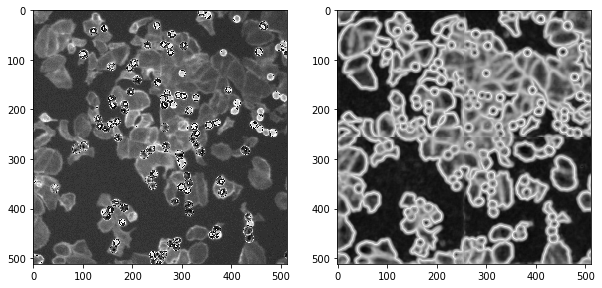

In [54]:
for i in range(0, len(X_test), 4):
    im = np.vstack([np.hstack([X_test[i], X_test[i + 2]]), np.hstack([X_test[i + 3], X_test[i + 1]])])
    mask = np.vstack([np.hstack([y_test[i][0][0], y_test[i + 2][0][0]]),
                      np.hstack([y_test[i + 3][0][0], y_test[i + 1][0][0]])])
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    plt.imshow(im, 'gray')
    plt.subplot(1,2,2)
    plt.imshow(mask, 'gray')
    plt.show()

In [77]:
y_test_binary = [i > 1.1 for i in y_test]

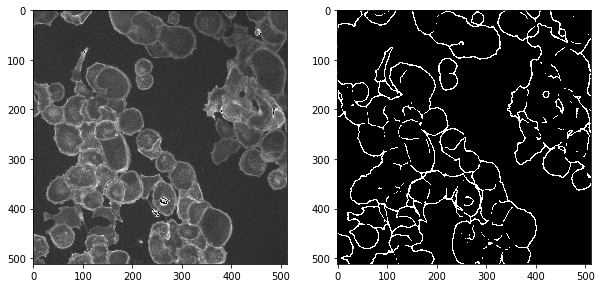

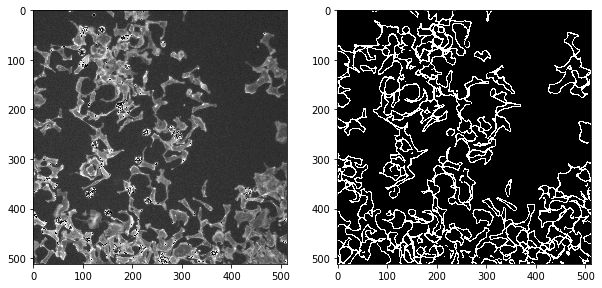

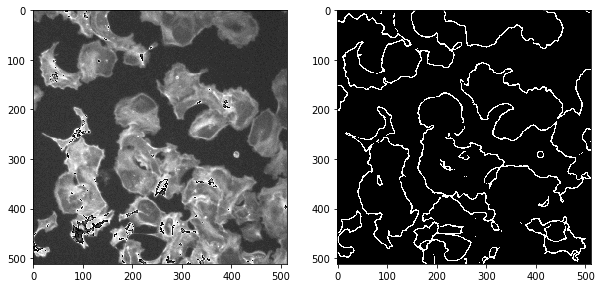

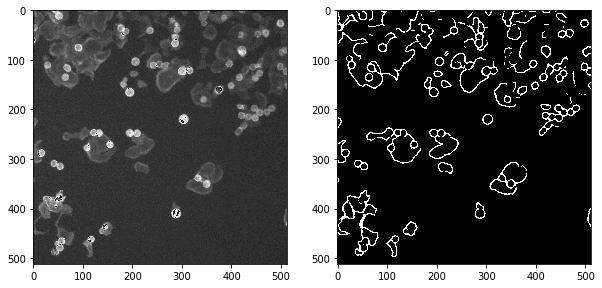

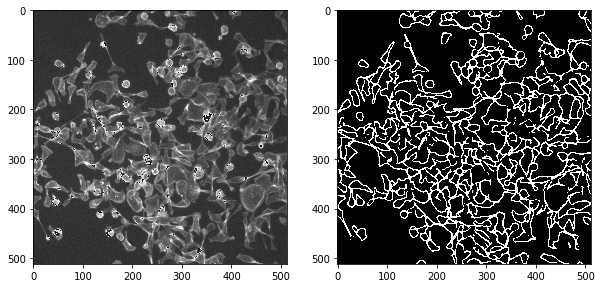

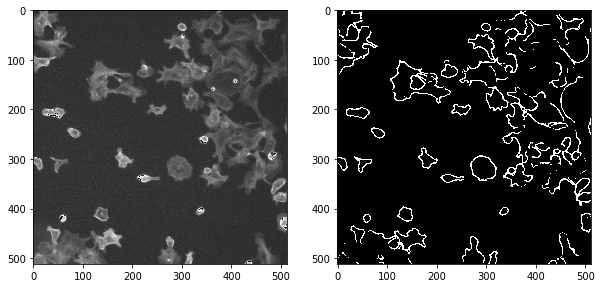

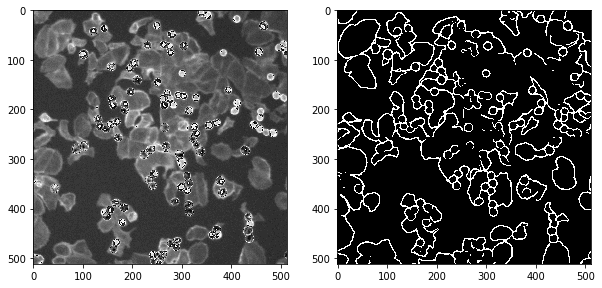

In [78]:
for i in range(0, len(X_test), 4):
    im = np.vstack([np.hstack([X_test[i], X_test[i + 2]]), np.hstack([X_test[i + 3], X_test[i + 1]])])
    mask = np.vstack([np.hstack([y_test_binary[i][0][0], y_test_binary[i + 2][0][0]]),
                      np.hstack([y_test_binary[i + 3][0][0], y_test_binary[i + 1][0][0]])])
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
    plt.imshow(im, 'gray')
    plt.subplot(1,2,2)
    plt.imshow(mask, 'gray')
    plt.show()

In [86]:
for i, path in zip(range(0, len(X_test), 4), test_loader.dataset.paths):
    mask = np.vstack([np.hstack([y_test_binary[i][0][0], y_test_binary[i + 2][0][0]]),
                      np.hstack([y_test_binary[i + 3][0][0], y_test_binary[i + 1][0][0]])])
    plt.imsave(str(path)[:-3] + 'png', mask, format='png')